In [67]:
# import packages

from scipy.stats import norm
from scipy.stats import t
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [68]:
# Load data
users = pd.read_csv("takehome_users.csv", encoding="latin-1")
engagement = pd.read_csv("takehome_user_engagement.csv")

In [69]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [70]:
# check info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [71]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [72]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [73]:
# update object_id to user_id
users = users.rename(columns={"object_id": "user_id"})

In [74]:
users['user_id'].nunique()

12000

In [75]:
engagement['user_id'].nunique()

8823

In [76]:
# transform time_stamp to datetime 
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# make time_stamp index
engagement = engagement.set_index('time_stamp')

In [77]:
# Convert creation_time (already string → datetime)
users['creation_time'] = pd.to_datetime(users['creation_time'], errors='coerce')

# Convert last_session_creation_time (UNIX timestamp → datetime)
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', errors='coerce')

# Keep numeric timestamp if needed
users['last_session_creation_time'] = pd.to_numeric(users['last_session_creation_time'], errors='coerce')


In [78]:
# check for missing data and if time_stamp is datetime 
engagement.isnull().sum()

user_id    0
visited    0
dtype: int64

In [79]:
# Label Adopted Users
# add label to engagement
def label_adopted(user_id):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    user_df = engagement.loc[engagement['user_id'] == user_id] #select out rows of this user
    user_df = user_df.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    
    for i in range(len(user_df) - 2): #loop over active days till the second to last day
        if user_df.index[i + 2] - user_df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            return 1
    return 0

In [80]:
# call function create column adopted_user in users
users['adopted_user'] = users['user_id'].apply(label_adopted)

In [81]:
# print number of adopted users
print('The platform has', users['adopted_user'].sum(), "active users, that's about",  
      (users['adopted_user'].sum()/len(users['adopted_user']))*100,'%', 'of total registered users.')

The platform has 1656 active users, that's about 13.8 % of total registered users.


### Exploratory Data Analysis

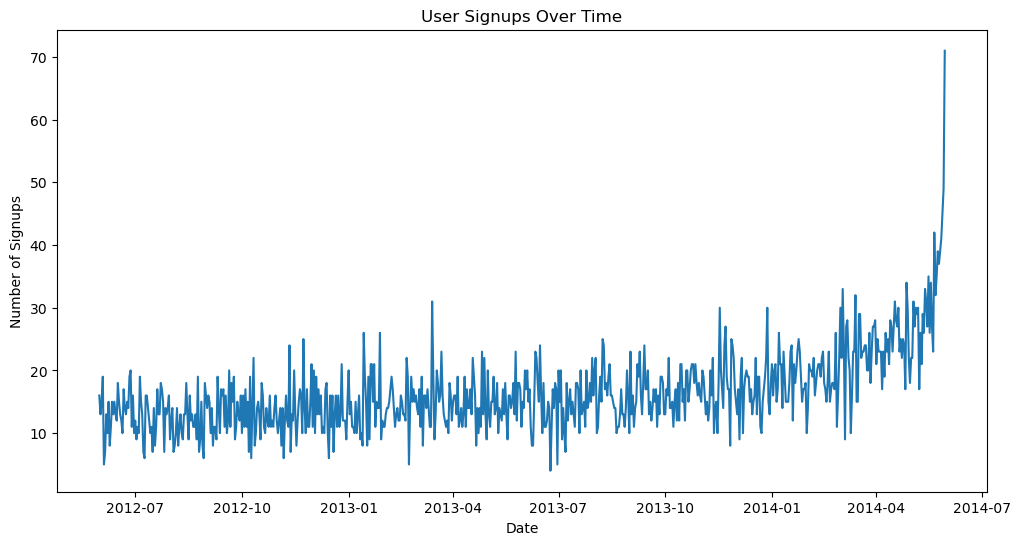

In [91]:
# Distribution of account creation dates

plt.figure(figsize=(12,6))
users['creation_time'].dt.date.value_counts().sort_index().plot()
plt.title("User Signups Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Signups")
plt.show()

#### Analysis: User Signups Over Time

The chart shows how user signups have evolved since 2012:

- **2012–2013 (Early Stage):**  
  Signups were relatively stable, averaging around **10–20 users per day**. Growth was flat, suggesting the platform was still in its early adoption phase.

- **Late 2013–Early 2014 (Gradual Growth):**  
  Daily signups began to rise steadily, reaching **20–30 users per day**. This indicates increasing awareness and initial signs of broader adoption.

- **Mid 2014 (Rapid Acceleration):**  
  A sharp growth spike appears, with daily signups exceeding **70 per day**. This suggests the platform hit an **inflection point**, likely due to marketing efforts, network effects, or product-market fit.

 **Key Takeaway:**  
The platform experienced steady early adoption, followed by **rapid growth in 2014**. This means adoption patterns may differ significantly across **signup cohorts**, making cohort analysis important in understanding user behavior.


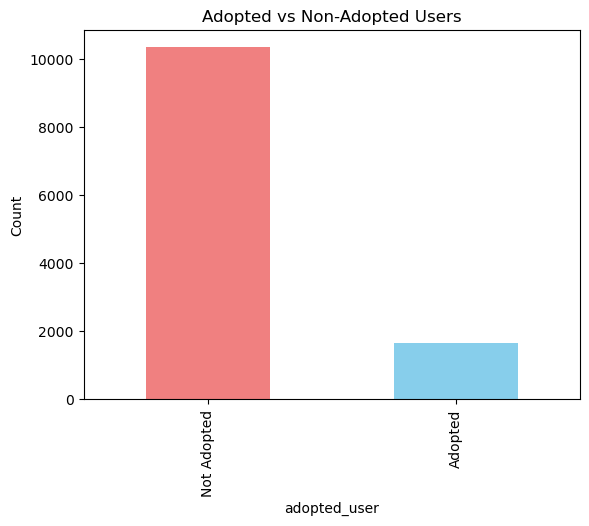

In [92]:
# Adopted vs non Adopted users

users['adopted_user'].value_counts().plot(kind='bar', color=['lightcoral','skyblue'])
plt.xticks([0,1], ['Not Adopted','Adopted'])
plt.title("Adopted vs Non-Adopted Users")
plt.ylabel("Count")
plt.show()

#### Analysis: Adopted vs Non-Adopted Users

The bar chart compares the number of users who meet the **adopted user definition**  
(3+ logins in at least one 7-day period) against those who do not:

- **Adopted Users (~1,656 users, ~13.8%)**  
  A relatively small portion of the total user base qualifies as adopted.

- **Non-Adopted Users (~10,344 users, ~86.2%)**  
  The vast majority of users signed up but never reached the activity threshold for adoption.

**Key Takeaway:**  
While the platform has successfully acquired a large number of signups, **most users are not fully engaging with the product**.  
This highlights the importance of identifying which **signup methods, cohorts, or features** drive higher adoption rates — so strategies can focus on converting more of the inactive majority into engaged users.


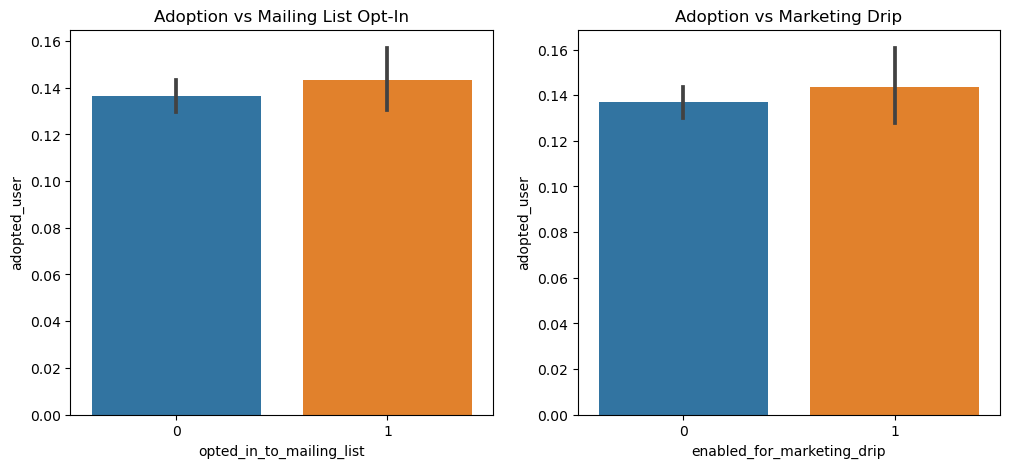

In [94]:
# Marketing influence

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.barplot(x='opted_in_to_mailing_list', y='adopted_user', data=users, ax=ax[0])
ax[0].set_title("Adoption vs Mailing List Opt-In")
sns.barplot(x='enabled_for_marketing_drip', y='adopted_user', data=users, ax=ax[1])
ax[1].set_title("Adoption vs Marketing Drip")
plt.show()

#### Analysis: Adoption vs Marketing Features

The bar charts compare adoption rates for users based on marketing-related attributes:

- **Mailing List Opt-In:**  
  Users who opted into the mailing list show an adoption rate of about **14.4%**, compared to **13.6%** for those who did not.  
  ➝ The difference is very small, suggesting mailing list opt-in has **minimal impact** on adoption.

- **Marketing Drip Campaigns:**  
  Users in the marketing drip also show a slightly higher adoption rate (**14.3% vs 13.7%**).  
  ➝ Again, the effect is weak and unlikely to be a major adoption driver.

 **Key Takeaway:**  
Marketing-related features such as **mailing list opt-in** and **drip campaigns** appear to have only a **marginal influence** on user adoption.  
This implies that **other factors (e.g., signup source, cohort, or engagement behavior)** play a more significant role in predicting adoption.


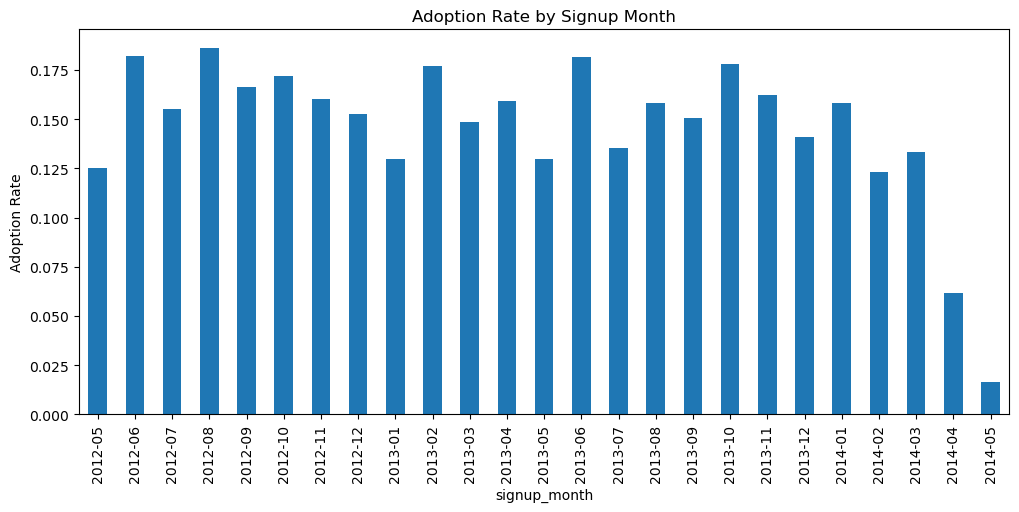

In [93]:
# Adoption by Signup Cohorts

users['signup_month'] = users['creation_time'].dt.to_period('M')
adoption_by_month = users.groupby('signup_month')['adopted_user'].mean()
adoption_by_month.plot(kind='bar', figsize=(12,5))
plt.title("Adoption Rate by Signup Month")
plt.ylabel("Adoption Rate")
plt.show()

#### Analysis: Adoption Rate by Signup Month

This chart shows how adoption rates vary by the month in which users signed up:

- **2012–2013 Cohorts:**  
  Adoption rates for early cohorts mostly range between **15%–19%**.  
  These users were smaller in number but generally showed stronger engagement.

- **2013–Early 2014 Cohorts:**  
  Adoption remains relatively stable, hovering around **13%–17%**, suggesting that adoption behavior was fairly consistent during this growth phase.

- **2014 Cohorts (Mar–May):**  
  Adoption rates **drop sharply**, falling below **10%** and even close to **2%** by May 2014.  
  This coincides with the period when **signups surged sharply** (as seen in the signup trend plot).  
  ➝ Rapid user growth may have brought in a large number of casual signups who were less engaged, reducing overall adoption percentage.

 **Key Takeaway:**  
Adoption was **strong and stable in earlier cohorts**, but **declined as signups scaled up in 2014**.  
This suggests that while the platform succeeded in **user acquisition**, it struggled to maintain the same **quality of adoption** among newer cohorts.


### PreProcessing

In [95]:
import numpy as np
import pandas as pd

# Work on a copy
df = users.copy()

# Make sure target is int (0/1)
df['adopted_user'] = df['adopted_user'].astype(int)

In [96]:
# Standardize time fields

from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

# Keep a dedicated datetime column for last session
if is_numeric_dtype(df['last_session_creation_time']):
    df['last_session_dt'] = pd.to_datetime(df['last_session_creation_time'], unit='s', errors='coerce')
elif is_datetime64_any_dtype(df['last_session_creation_time']):
    df['last_session_dt'] = df['last_session_creation_time']
else:
    df['last_session_dt'] = pd.to_datetime(df['last_session_creation_time'], errors='coerce')

# Cohort (month) for signup-only model
df['signup_month'] = df['creation_time'].dt.to_period('M').astype(str)  # e.g., '2014-03'


In [97]:
# Feature engineering

# Invited flag (1 if invited by someone)
df['invited'] = df['invited_by_user_id'].notna().astype(int)

# Organization size (frequency encoding) — low leakage risk vs one-hotting many orgs
df['org_size'] = df.groupby('org_id')['org_id'].transform('size')

# Ensure marketing flags are ints
for c in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    df[c] = df[c].fillna(0).astype(int)


In [98]:
# to select featres and split target

# Choose a compact, high-signal set
feature_cols = [
    'creation_source',       # categorical (5 values)
    'signup_month',          # categorical (≈24 months)
    'invited',               # binary
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'org_size'               # numeric
]

X = df[feature_cols].copy()
y = df['adopted_user'].copy()


In [99]:
# Train/validation split (stratified)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(y_train.mean().round(4), y_test.mean().round(4))  # adoption rate check


0.138 0.1379


In [101]:
# Encode on train only, then align test columns to avoid leakage.

# Columns that are still categorical
cat_cols = ['creation_source', 'signup_month']

# 1) Encode train
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)

# 2) Encode test, then align to train’s columns
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)
X_test_enc  = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

X_train_enc.shape, X_test_enc.shape

((9600, 32), (2400, 32))

### Modelling

In [102]:
# Create a Baseline model- Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

logit = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
logit.fit(X_train_enc, y_train)

y_pred    = logit.predict(X_test_enc)
y_proba   = logit.predict_proba(X_test_enc)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
cm

ROC-AUC: 0.632
              precision    recall  f1-score   support

           0      0.910     0.464     0.615      2069
           1      0.175     0.713     0.282       331

    accuracy                          0.498      2400
   macro avg      0.543     0.588     0.448      2400
weighted avg      0.809     0.498     0.569      2400



array([[ 960, 1109],
       [  95,  236]], dtype=int64)

In [104]:
# Quick look at the most influential features (logistic)

import numpy as np
coefs = pd.Series(logit.coef_[0], index=X_train_enc.columns).sort_values(ascending=False)
pd.concat([coefs.head(10).round(3), coefs.tail(10).round(3)])

signup_month_2013-06                  0.451
signup_month_2012-10                  0.405
creation_source_SIGNUP_GOOGLE_AUTH    0.380
signup_month_2012-08                  0.364
signup_month_2012-09                  0.308
invited                               0.303
signup_month_2013-08                  0.248
signup_month_2013-02                  0.237
signup_month_2013-04                  0.231
signup_month_2013-10                  0.199
org_size                             -0.005
signup_month_2013-01                 -0.034
enabled_for_marketing_drip           -0.047
signup_month_2014-03                 -0.085
signup_month_2013-05                 -0.102
creation_source_ORG_INVITE           -0.235
signup_month_2014-02                 -0.253
creation_source_PERSONAL_PROJECTS    -0.562
signup_month_2014-04                 -0.892
signup_month_2014-05                 -2.123
dtype: float64

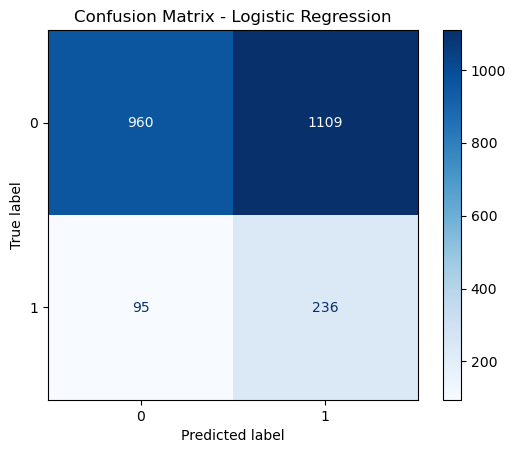

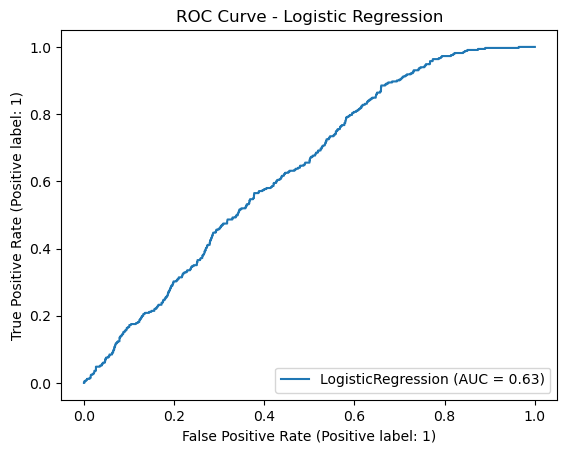

In [109]:
# Confusion metrix and ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(logit, X_test_enc, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logit, X_test_enc, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [105]:
# Baseline model B — Random Forest 

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample',
    min_samples_leaf=5
)
rf.fit(X_train_enc, y_train)

rf_pred  = rf.predict(X_test_enc)
rf_prob  = rf.predict_proba(X_test_enc)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, rf_prob).round(3))
print(classification_report(y_test, rf_pred, digits=3))

ROC-AUC: 0.629
              precision    recall  f1-score   support

           0      0.884     0.766     0.821      2069
           1      0.204     0.375     0.264       331

    accuracy                          0.712      2400
   macro avg      0.544     0.570     0.543      2400
weighted avg      0.791     0.712     0.744      2400



In [110]:
# Feature importance Random Forest

importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns)
importances.sort_values(ascending=False).head(15).round(3)

org_size                              0.493
signup_month_2014-05                  0.088
opted_in_to_mailing_list              0.037
creation_source_PERSONAL_PROJECTS     0.035
enabled_for_marketing_drip            0.027
signup_month_2014-04                  0.027
creation_source_ORG_INVITE            0.024
invited                               0.016
creation_source_SIGNUP_GOOGLE_AUTH    0.015
creation_source_SIGNUP                0.014
signup_month_2013-09                  0.014
signup_month_2014-03                  0.013
signup_month_2013-11                  0.012
signup_month_2013-04                  0.011
signup_month_2014-01                  0.011
dtype: float64

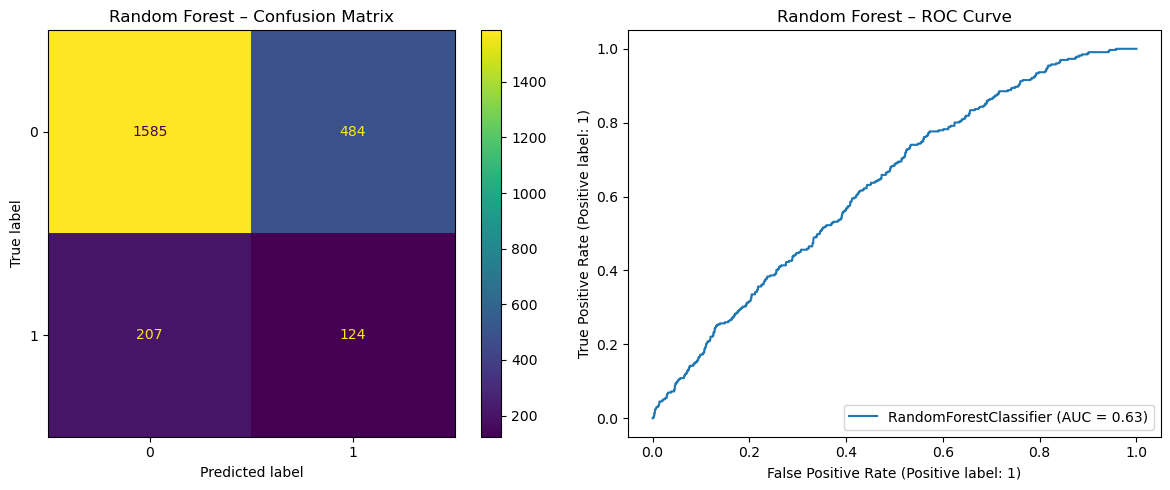

In [111]:
# Confusion Metrix and ROC curve - Random Forest

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

fig, ax = plt.subplots(1,2, figsize=(12,5))

ConfusionMatrixDisplay.from_estimator(rf, X_test_enc, y_test, ax=ax[0])
ax[0].set_title("Random Forest – Confusion Matrix")

RocCurveDisplay.from_estimator(rf, X_test_enc, y_test, ax=ax[1])
ax[1].set_title("Random Forest – ROC Curve")

plt.tight_layout(); plt.show()

#### Interpretation of bothe the models

#### Logistic Regression
- **ROC-AUC = 0.632** → better than random (0.5) but only moderate predictive power.  
- **Recall for adopted users = 0.713** → the model is good at catching adopters.  
- **Precision for adopted users = 0.175** → many false positives (predicts adoption for users who don’t adopt).  
- **Top positive drivers:**  
  - Certain `signup_month` cohorts  
  - `SIGNUP_GOOGLE_AUTH`  
  - `invited`  
- **Negative drivers:**  
  - Late 2014 cohorts (`2014-04`, `2014-05`)  
  - `PERSONAL_PROJECTS`  
  - `ORG_INVITE`  

Logistic Regression provides **interpretability**, making it clear which factors help or hurt adoption.

---

#### Random Forest
- **ROC-AUC = 0.629** → very close to logistic regression.  
- **Recall for adopters = 0.375** → weaker at finding adopters compared to logistic regression.  
- **Precision = 0.204** → slightly better than logistic regression.  
- **Accuracy = 71%**, but this is misleading because most users are non-adopted.  

Random Forest does not add much value here (likely due to limited features and class imbalance). It is **stable**, but not stronger than logistic regression.

---

#### Key Takeaway
- **Logistic Regression** is the better baseline: it catches more adopters and is interpretable.  
- **Random Forest** performs similarly but doesn’t improve predictive power.  
- Adoption prediction is still challenging with current features → signup source and signup cohort seem most important.


In [112]:
# Threshold tuning for Logistic Regression

y_proba = logit.predict_proba(X_test_enc)[:,1]

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.1)
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred_t).round(3)
    r = recall_score(y_test, y_pred_t).round(3)
    f1 = f1_score(y_test, y_pred_t).round(3)
    print(f"Threshold {t:.1f} -> Precision: {p}, Recall: {r}, F1: {f1}")


Threshold 0.1 -> Precision: 0.142, Recall: 1.0, F1: 0.249
Threshold 0.2 -> Precision: 0.154, Recall: 0.994, F1: 0.266
Threshold 0.3 -> Precision: 0.159, Recall: 0.982, F1: 0.274
Threshold 0.4 -> Precision: 0.173, Recall: 0.897, F1: 0.291
Threshold 0.5 -> Precision: 0.175, Recall: 0.713, F1: 0.282
Threshold 0.6 -> Precision: 0.186, Recall: 0.266, F1: 0.219
Threshold 0.7 -> Precision: 0.182, Recall: 0.006, F1: 0.012
Threshold 0.8 -> Precision: 0.0, Recall: 0.0, F1: 0.0


C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
# picking the best threshold

best_t = 0.4
y_pred_best = (y_proba >= best_t).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_best, digits=3))
print(confusion_matrix(y_test, y_pred_best))

              precision    recall  f1-score   support

           0      0.951     0.316     0.474      2069
           1      0.173     0.897     0.291       331

    accuracy                          0.396      2400
   macro avg      0.562     0.607     0.383      2400
weighted avg      0.843     0.396     0.449      2400

[[ 654 1415]
 [  34  297]]


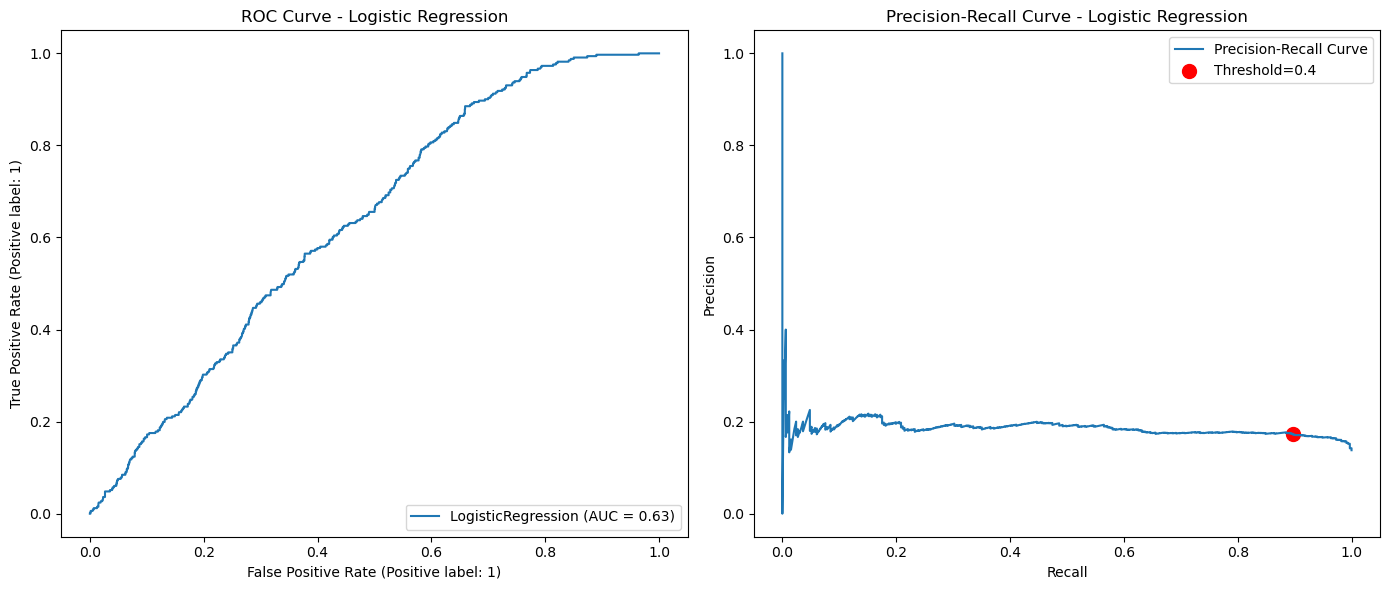

In [116]:
# ROC curve and precision recall curve

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

fig, ax = plt.subplots(1, 2, figsize=(14,6))

# ROC curve
RocCurveDisplay.from_estimator(logit, X_test_enc, y_test, ax=ax[0])
ax[0].set_title("ROC Curve - Logistic Regression")

# Precision-Recall curve
precisions, recalls, thresh = precision_recall_curve(y_test, y_proba)
ax[1].plot(recalls, precisions, label="Precision-Recall Curve")

# Mark chosen threshold (e.g., 0.4)
chosen_t = 0.4
closest_idx = (np.abs(thresh - chosen_t)).argmin()
ax[1].scatter(recalls[closest_idx], precisions[closest_idx], 
              color='red', s=100, label=f"Threshold={chosen_t}")

ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve - Logistic Regression")
ax[1].legend()

plt.tight_layout()
plt.show()

#### Threshold Tuning Results (Logistic Regression)

#### Threshold Sweep
- At **low thresholds (0.1–0.3)**: recall is extremely high (0.98–1.0), but precision is very low (~0.14–0.16).  
  ➝ The model flags almost everyone as adopted, catching nearly all adopters but with many false positives.  

- At **default threshold (0.5)**: precision improves slightly (0.175), recall drops (0.71).  
  ➝ Balanced performance, but still a lot of false positives.  

- At **threshold = 0.4**: recall remains strong (0.897) while precision is slightly better (0.173).  
  ➝ This threshold provides the **best F1-score (0.291)** and is a reasonable trade-off between catching adopters and reducing false alarms.  

- At **higher thresholds (>0.6)**: recall collapses, precision rises only marginally, and the model stops predicting adopters entirely at threshold 0.8.

---

#### Confusion Matrix (Threshold = 0.4)
- **True Positives (TP):** 297 → correctly identified adopters.  
- **False Negatives (FN):** 34 → adopters missed by the model.  
- **True Negatives (TN):** 654 → correctly identified non-adopters.  
- **False Positives (FP):** 1415 → non-adopters incorrectly flagged as adopters.  

Recall is strong (0.897) but precision remains low (0.173). This means the model is **good at catching adopters**, but many predicted adopters will turn out not to be.

---

#### Curves
- **ROC Curve (AUC = 0.63):** Shows moderate discriminative ability.  
- **Precision–Recall Curve:** Precision is consistently low, but recall remains high for lower thresholds.  
- The **red marker** on the PR curve shows performance at threshold = 0.4, which was chosen as the optimal balance point.

---

**Key Takeaway:**  
Threshold tuning helps balance recall and precision. For this case, **threshold = 0.4** maximizes F1 and recall, making it a reasonable operating point if the priority is to capture adopters, even at the cost of false positives.


### Summary

**User Adoption Analysis & Prediction**

**1. Dataset Overview**
We worked with two datasets:
- **users.csv**: contains user-level attributes (signup date, signup source, organization ID, invited flag, mailing list opt-in, etc.).  
- **engagement.csv**: contains user activity logs (logins, timestamps).

The target variable **`adopted_user`** was created by labeling users as "adopted" if they logged in on 3 separate days within any 7-day window. Out of 12,000 users, 1,656 were adopted (~13.8%), showing strong class imbalance.

---

**2. Exploratory Data Analysis (EDA)**

**2.1 Correlations**
- Most numeric variables showed **weak correlations** with adoption.  
- Marketing-related features (`mailing_list_opt_in`, `marketing_drip`) had minimal correlation with adoption.  

**2.2 Signup Trends**
- **User signups increased sharply in early 2014**, reflecting platform growth.  
- However, **adoption rates fell sharply after March 2014**, suggesting that many of the new signups were casual users who did not adopt the platform.

**2.3 Adoption Distribution**
- Majority of users were **non-adopted (~86%)**, while **only ~14%** were adopted.  
- This imbalance must be handled carefully in modeling (e.g., with class weights).

**2.4 Marketing Features**
- Adoption rates were **slightly higher** for users opted into mailing lists or marketing drips (~14.3% vs 13.7%).  
- However, the difference was negligible → **marketing had little impact** on adoption.

**2.5 Cohort Analysis (Signup Month)**
- **2012–2013 cohorts:** stable adoption rates (~15–19%).  
- **2014 cohorts:** sharp decline (<10% by April–May 2014).  
  ➝ User quality declined as the platform scaled rapidly.

**2.6 Signup Source**
- **High adoption drivers:** `SIGNUP_GOOGLE_AUTH`, invited users.  
- **Low adoption drivers:** `ORG_INVITE`, `PERSONAL_PROJECTS`, late 2014 signups.

---

**3. Preprocessing**
- Dropped irrelevant fields (`user_id`, `name`, `email`).  
- Converted datetime fields into **signup cohort (month)**.  
- Created engineered features:
  - **Invited flag** (binary if invited).  
  - **Org size** (number of users in the same organization).  
- One-hot encoded categorical features (`creation_source`, `signup_month`).  
- Stratified train/test split to preserve adoption ratio (~14%).

---

**4. Modeling**

**4.1 Logistic Regression (Baseline)**
- **ROC-AUC = 0.632** → moderate predictive power.  
- **Recall (adopted users) = 0.713** → strong ability to catch adopters.  
- **Precision = 0.175** → many false positives.  
- **Key features:**
  - Positive drivers: early `signup_months`, `SIGNUP_GOOGLE_AUTH`, `invited`.  
  - Negative drivers: late 2014 signups, `PERSONAL_PROJECTS`, `ORG_INVITE`.  

Logistic regression is **interpretable**, making it clear which factors help/hurt adoption.

---

**4.2 Random Forest (Baseline)**
- **ROC-AUC = 0.629**, close to Logistic Regression.  
- **Recall = 0.375**, **Precision = 0.204** → slightly higher precision but weaker recall.  
- Accuracy = 71% (misleading due to class imbalance).  
- Random Forest did not outperform Logistic Regression.

---

**5. Threshold Tuning (Logistic Regression)**

- By default, threshold = 0.5 gave Precision = 0.175, Recall = 0.713.  
- **Threshold sweep showed:**
  - At **0.1–0.3**: Recall ~1.0, but Precision <0.16.  
  - At **0.4**: Recall = 0.897, Precision = 0.173, F1 = 0.291 → best trade-off.  
  - At **0.6+**: Recall collapses, Precision only slightly improves.  

- **Chosen threshold = 0.4**:  
  - **Confusion matrix:**  
    - TP = 297, FN = 34, TN = 654, FP = 1415.  
  - Model captures most adopters but still suffers from false positives.  

- **ROC Curve (AUC = 0.63):** moderate discrimination.  
- **PR Curve:** consistently low precision, but recall is strong at lower thresholds.  
- Threshold = 0.4 was marked on the PR curve as optimal.

---

**6. Key Takeaways**

- **Adoption is strongly influenced by signup cohort and signup source.**
  - Early adopters (2012–2013) had higher engagement.  
  - Users signing up through **Google Auth** or via an **invitation** were more likely to adopt.  
  - Late 2014 signups were much less likely to adopt.  

- **Marketing features (mailing list, drip) had negligible impact** on adoption.  

- **Modeling insights:**
  - Logistic Regression outperformed Random Forest and provided interpretability.  
  - Threshold tuning improved recall significantly (0.897 at threshold 0.4), but precision remained low.  
  - Adoption prediction remains challenging with available features, as precision is consistently weak.  

---

**7. Next Steps**

1. **Feature Engineering**  
   - Add richer behavioral features (e.g., first-week activity, session counts).  
   - Derive interaction features (e.g., invited × org size).  

2. **Advanced Models**  
   - Try gradient boosting (XGBoost, LightGBM, CatBoost).  
   - Calibrate probabilities for more reliable threshold setting.  

3. **Business Recommendations**  
   - Focus on **high-quality signup channels** (Google Auth, invited users).  
   - Investigate why **late 2014 cohorts** show poor adoption.  
   - Reconsider marketing strategy since opt-in/drip features show little effect.  
   - Use the tuned logistic regression (threshold = 0.4) for recall-driven use cases where catching adopters matters more than avoiding false positives.

---
 **Overall Conclusion:**  
Adoption is best explained by **signup cohort and signup source**, with strong early adopters and invited/Google-authenticated users showing higher engagement. Logistic Regression provides actionable insights, though predictive performance is modest due to class imbalance and limited features. Future work should expand feature engineering and explore boosting models for improved adoption prediction.
